Here are a few predictive analysis methods using PyTorch and TensorFlow, along with examples using well-known open-source datasets.

### 1. **LSTM for Time Series Forecasting**
**Dataset**: [Air Quality Data](https://archive.ics.uci.edu/ml/datasets/Air+Quality)

#### PyTorch Example
```python
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset

# Load and preprocess data
data = pd.read_csv('AirQualityUCI.csv', sep=';', decimal=',', parse_dates=['Date'], dayfirst=True)
data = data[['Date', 'CO(GT)']].dropna()  # Use CO concentration as the target
data['CO(GT)'] = data['CO(GT)'].astype(float)

scaler = MinMaxScaler()
data['CO(GT)'] = scaler.fit_transform(data[['CO(GT)']])

# Create dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, data, window_size):
        self.data = data.values
        self.window_size = window_size

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        return (self.data[idx:idx + self.window_size], self.data[idx + self.window_size])

window_size = 10
dataset = TimeSeriesDataset(data['CO(GT)'], window_size)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# Training the model
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(100):
    for seq, labels in dataloader:
        seq = seq.unsqueeze(-1)  # Add feature dimension
        optimizer.zero_grad()
        y_pred = model(seq.float())
        loss = criterion(y_pred, labels.float())
        loss.backward()
        optimizer.step()

# Make predictions
with torch.no_grad():
    predictions = model(seq.float())
```

### 2. **Transformer for Time Series Forecasting**
**Dataset**: [Energy Consumption Data](https://www.kaggle.com/datasets/uciml/electricity-load-diagrams-20112014)

#### TensorFlow Example
```python
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# Load and preprocess data
data = pd.read_csv('electricity_consumption.csv', parse_dates=['Date'])
data = data[['Date', 'Consumption']].dropna()
data['Consumption'] = MinMaxScaler().fit_transform(data[['Consumption']])

# Prepare the data for the transformer
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 24
X, y = create_dataset(data['Consumption'].values.reshape(-1, 1), time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Define Transformer model
class TransformerModel(tf.keras.Model):
    def __init__(self, num_heads=2, ff_dim=32):
        super(TransformerModel, self).__init__()
        self.attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=1)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation='relu'),
            tf.keras.layers.Dense(1)
        ])
        self.layer_norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, x):
        attn_output = self.attention(x, x)
        out1 = self.layer_norm1(x + attn_output)
        ffn_output = self.ffn(out1)
        return self.layer_norm2(out1 + ffn_output)

# Compile and train the model
model = TransformerModel()
model.compile(optimizer='adam', loss='mse')

model.fit(X, y, epochs=10, batch_size=32)

# Make predictions
predictions = model.predict(X)
```

### 3. **BERT for Text Classification**
**Dataset**: [IMDB Movie Reviews](https://ai.stanford.edu/~amaas/data/sentiment/)

#### Using Hugging Face Transformers
```python
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments

# Load the dataset
data = pd.read_csv('IMDB Dataset.csv')
data = data[['review', 'sentiment']].dropna()

# Tokenize the data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
encodings = tokenizer(data['review'].tolist(), truncation=True, padding=True)

# Prepare the dataset
class IMDBDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

dataset = IMDBDataset(encodings, data['sentiment'].map({'positive': 1, 'negative': 0}).tolist())

# Load BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    save_steps=10_000,
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
)

# Train the model
trainer.train()
```

### Summary
These examples illustrate how to apply various predictive analysis methods using popular frameworks like PyTorch and TensorFlow, utilizing well-known datasets. Adjustments can be made to hyperparameters, model architecture, and preprocessing steps to improve performance based on specific requirements.

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset

# Load and preprocess data
data = pd.read_csv('AirQualityUCI.csv', sep=';', decimal=',', parse_dates=['Date'], dayfirst=True)
data = data[['Date', 'CO(GT)']].dropna()  # Use CO concentration as the target
data['CO(GT)'] = data['CO(GT)'].astype(float)

scaler = MinMaxScaler()
data['CO(GT)'] = scaler.fit_transform(data[['CO(GT)']])

# Create dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, data, window_size):
        self.data = data.values
        self.window_size = window_size

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        return (self.data[idx:idx + self.window_size], self.data[idx + self.window_size])

window_size = 10
dataset = TimeSeriesDataset(data['CO(GT)'], window_size)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# Training the model
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(100):
    for seq, labels in dataloader:
        seq = seq.unsqueeze(-1)  # Add feature dimension
        optimizer.zero_grad()
        y_pred = model(seq.float())
        loss = criterion(y_pred, labels.float())
        loss.backward()
        optimizer.step()

# Make predictions
with torch.no_grad():
    predictions = model(seq.float())


FileNotFoundError: [Errno 2] No such file or directory: 'AirQualityUCI.csv'

Analyzing forecasting errors is essential for understanding the performance of predictive models. Here’s a structured approach to analyze forecasting errors, including common metrics, techniques, and visualizations:

### 1. **Forecasting Error Metrics**
Use various metrics to quantify the accuracy of your forecasts. Here are some commonly used error metrics:

- **Mean Absolute Error (MAE)**:
  \[
  \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
  \]
  Measures the average magnitude of errors without considering their direction.

- **Mean Squared Error (MSE)**:
  \[
  \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
  \]
  Penalizes larger errors more than smaller ones.

- **Root Mean Squared Error (RMSE)**:
  \[
  \text{RMSE} = \sqrt{\text{MSE}}
  \]
  Provides error in the same units as the data.

- **Mean Absolute Percentage Error (MAPE)**:
  \[
  \text{MAPE} = \frac{100}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right|
  \]
  Expresses error as a percentage, making it easier to interpret.

### 2. **Visualizing Forecast Errors**
Visualizations can help identify patterns and trends in forecasting errors:

- **Error Distribution Plot**:
  Create a histogram or density plot of the forecasting errors to visualize their distribution.

- **Time Series Plot**:
  Plot actual vs. forecasted values along with the errors (e.g., actual - forecasted) to observe patterns over time.

- **Residual Plot**:
  Plot residuals (errors) against predicted values. Look for patterns; ideally, they should be randomly distributed around zero.

- **Cumulative Error Plot**:
  Plot cumulative errors to see if they are trending positively or negatively over time.

### 3. **Decomposing Errors**
Analyze errors by decomposing them into components:

- **Bias**: Check if there is a systematic overestimation or underestimation of forecasts. Calculate the mean of the errors; if it is significantly different from zero, there is bias.

- **Variance**: Assess how spread out the errors are. High variance indicates that the model's performance is inconsistent across different periods.

- **Seasonality**: Investigate whether errors are affected by seasonality. Use techniques like seasonal decomposition to analyze patterns.

### 4. **Error Analysis Techniques**
- **Cross-Validation**: Use techniques like k-fold or time series cross-validation to evaluate model performance over different subsets of data.
  
- **Benchmarking**: Compare the forecasting model against a simple benchmark model (e.g., naive forecast or mean forecast) to determine if it provides significant improvements.

- **Error Correction**: Identify systematic errors and apply corrective methods, such as adjusting the model parameters or incorporating additional features.

### 5. **Example Analysis in Python**
Here’s a simple example of analyzing forecasting errors using Python and matplotlib:

```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Example data: actual vs. predicted values
actual = np.array([100, 150, 200, 250, 300])
predicted = np.array([110, 140, 210, 240, 290])

# Calculate errors
errors = actual - predicted
mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
mape = np.mean(np.abs(errors / actual)) * 100

# Print metrics
print(f'MAE: {mae}, MSE: {mse}, RMSE: {rmse}, MAPE: {mape:.2f}%')

# Visualizations
plt.figure(figsize=(12, 6))

# Plot actual vs predicted
plt.subplot(1, 2, 1)
plt.plot(actual, label='Actual', marker='o')
plt.plot(predicted, label='Predicted', marker='x')
plt.title('Actual vs Predicted')
plt.legend()

# Plot errors
plt.subplot(1, 2, 2)
plt.hist(errors, bins=5, edgecolor='black')
plt.title('Error Distribution')
plt.xlabel('Errors')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
```

### Conclusion
Analyzing forecasting errors helps to refine models and improve accuracy. By using various metrics, visualizations, and decomposition techniques, you can gain insights into the strengths and weaknesses of your forecasting approach, leading to more reliable predictions.

MAE: 10.0, MSE: 100.0, RMSE: 10.0, MAPE: 5.80%


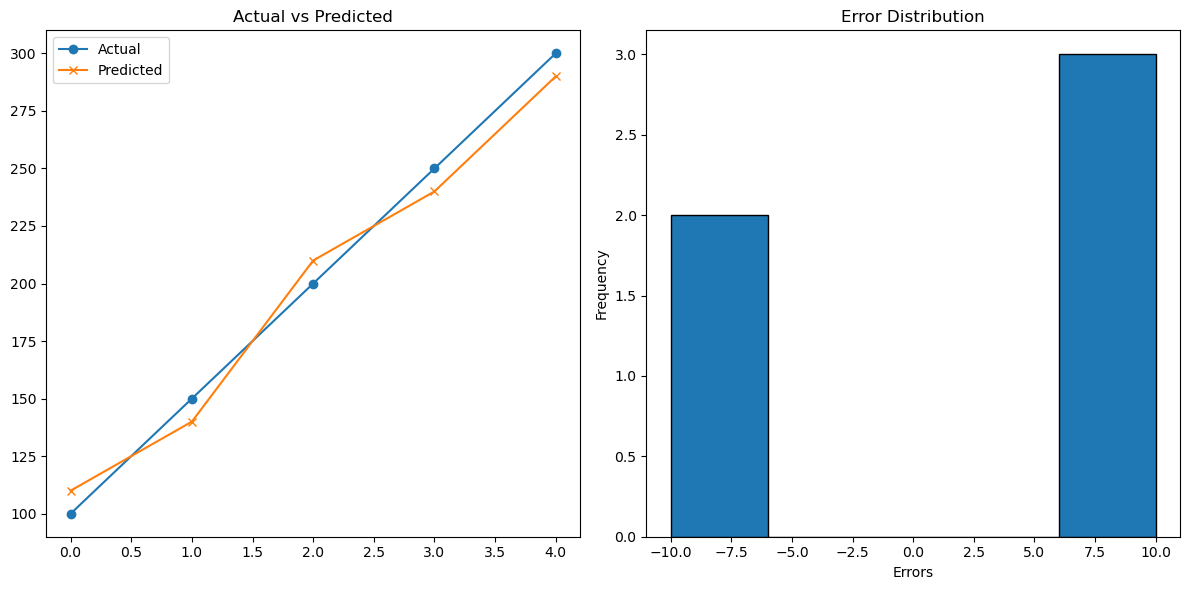

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Example data: actual vs. predicted values
actual = np.array([100, 150, 200, 250, 300])
predicted = np.array([110, 140, 210, 240, 290])

# Calculate errors
errors = actual - predicted
mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
mape = np.mean(np.abs(errors / actual)) * 100

# Print metrics
print(f'MAE: {mae}, MSE: {mse}, RMSE: {rmse}, MAPE: {mape:.2f}%')

# Visualizations
plt.figure(figsize=(12, 6))

# Plot actual vs predicted
plt.subplot(1, 2, 1)
plt.plot(actual, label='Actual', marker='o')
plt.plot(predicted, label='Predicted', marker='x')
plt.title('Actual vs Predicted')
plt.legend()

# Plot errors
plt.subplot(1, 2, 2)
plt.hist(errors, bins=5, edgecolor='black')
plt.title('Error Distribution')
plt.xlabel('Errors')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
